# 数据操作

## ChunkedDataset

In [14]:
from dataloading import get_chunked_h5dataloader
from constants import KEY_LM_INPUT_IDS, KEY_LM_HIDDEN_STATES, KEY_LM_LABELS

dataloader = get_chunked_h5dataloader(
    config_path='conf/data/example_openai_pt.yaml',
    split='test',
)

for batch in dataloader:
    input_ids = batch[KEY_LM_INPUT_IDS]
    labels = batch[KEY_LM_LABELS]
    hidden_states = batch[KEY_LM_HIDDEN_STATES]
    
    print(f"Input IDs: {input_ids.shape}")
    print(f"Labels: {labels.shape}")
    print(f"Hidden States: {hidden_states.shape}")
    break  # 这里只打印一个批次的数据

Input IDs: torch.Size([256, 1024])
Labels: torch.Size([256, 1024])
Hidden States: torch.Size([256, 256, 768])


In [15]:
import numpy as np
import torch.nn.functional as F

def calculate_dataset_stats(dataloader, ratio=0.7):
    total_loss = 0
    total_samples = 0
    # 遍历整个数据集并收集所有的 hidden_states
    for i, batch in enumerate(dataloader):
        hidden_states = batch[KEY_LM_HIDDEN_STATES]
        out = ratio * hidden_states
        # out = out.clamp(-1., 1.)
        rec_loss = F.mse_loss(out, hidden_states)
        total_loss += rec_loss.item() * hidden_states.shape[0]
        total_samples += hidden_states.shape[0]
    total_loss /= total_samples
    return total_loss    

# 示例用法：
for ratio in range(60, 100, 2):
    ratio = 0.01*ratio
    total_loss = calculate_dataset_stats(dataloader, ratio)
    print("%.2f"%(ratio), f":{total_loss}")

0.60 :1.0654203604607686
0.62 :0.9615419763718208
0.64 :0.8629906960647472
0.66 :0.7697661658273126
0.68 :0.6818690930839872
0.70 :0.5992990684335249
0.72 :0.5220559130619912
0.74 :0.4501401296932332
0.76 :0.38355142421966054
0.78 :0.3222897946834564
0.80 :0.26635509011519215
0.82 :0.2157476730372784
0.84 :0.17046733385454998
0.86 :0.1305139782654978
0.88 :0.09588784909378874
0.90 :0.06658881723228162
0.92 :0.04261679969129771
0.94 :0.02397196376900168
0.96 :0.01065421656426722
0.98 :0.0026635462401203647


## H5py直接操作

- 模型来自 https://huggingface.co/neulab/gpt2-finetuned-wikitext103
- 模型tokenizer和定义如下
```
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("neulab/gpt2-finetuned-wikitext103")
model = AutoModelForCausalLM.from_pretrained("neulab/gpt2-finetuned-wikitext103")
```

In [9]:
import h5py

h5filename = '/home/yxwang/Dataset/vqhlm/wikitext103_gpt2finetuned/test.h5'
f = h5py.File(h5filename, 'r')
len(f['hidden_states'])

274

In [7]:
# 读取 HDF5 文件
with h5py.File(h5filename, 'r') as f:
    # 读取 total_samples 元数据
    total_samples = f.attrs['total_samples']
    print(f"Total samples in the dataset: {total_samples}")
    
    # 读取数据集
    hidden_states = f['hidden_states'][:]
    input_ids = f['input_ids'][:]
    labels = f['labels'][:]

    # 打印数据集的形状，确保读取正确
    print(f"Hidden states shape: {hidden_states.shape}")
    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # 获取第一个样本的数据并展示
    sample_idx = 0  # 举例，读取第一个样本
    print(f"Sample {sample_idx} - Input IDs: {input_ids[sample_idx]}")
    print(f"Sample {sample_idx} - Labels: {labels[sample_idx]}")
    
    # 获取对应的 hidden states (flattened)
    print(f"Sample {sample_idx} - Hidden States: {hidden_states[sample_idx]}")

Total samples in the dataset: 548
Hidden states shape: (548, 1024, 768)
Input IDs shape: (548, 1024)
Labels shape: (548, 1024)
Sample 0 - Input IDs: [  796  5199   347 ... 50256 50256 50256]
Sample 0 - Labels: [ 796 5199  347 ... -100 -100 -100]
Sample 0 - Hidden States: [[-1.6174933  -1.1284641   0.0215988  ... -2.2583933   1.6741287
  -0.35499385]
 [-5.498198    2.3329258  -2.2865224  ...  0.42031875  0.07713613
   1.1435596 ]
 [ 1.8659987   1.5455958   1.0896978  ...  3.514292   -0.08421862
   3.3854916 ]
 ...
 [ 0.798916    2.5979886  -0.07587534 ... -0.737859   -1.1983643
   4.190173  ]
 [ 0.7338563   2.760131   -0.01490831 ... -0.6301186  -1.1114419
   4.6592402 ]
 [ 0.7557825   1.4493941  -3.1341372  ... -2.043258    0.9624741
   5.8210287 ]]


## 预览index frequencies（需要已经跑完test）

Data loaded from CSV: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 3, 7: 0, 8: 1, 9: 1, 10: 0, 11: 2, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 1, 19: 2, 20: 0, 21: 2, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 1, 30: 0, 31: 0, 32: 0, 33: 0, 34: 4, 35: 1, 36: 1, 37: 0, 38: 0, 39: 0, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 1, 49: 1, 50: 0, 51: 3, 52: 0, 53: 1, 54: 0, 55: 0, 56: 2, 57: 1, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 1, 66: 0, 67: 1, 68: 0, 69: 0, 70: 0, 71: 3, 72: 1, 73: 1, 74: 0, 75: 0, 76: 0, 77: 1, 78: 0, 79: 0, 80: 0, 81: 1, 82: 1, 83: 1, 84: 0, 85: 0, 86: 2, 87: 0, 88: 0, 89: 0, 90: 0, 91: 2, 92: 0, 93: 1, 94: 1, 95: 0, 96: 1, 97: 0, 98: 3, 99: 0, 100: 2, 101: 4, 102: 0, 103: 0, 104: 2, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 1, 116: 0, 117: 0, 118: 0, 119: 1, 120: 0, 121: 0, 122: 0, 123: 0, 124: 2, 125: 0, 126: 2, 127: 1, 128: 0, 129: 0, 130: 1, 131: 1, 132: 0, 133: 0, 134: 0, 135: 1,

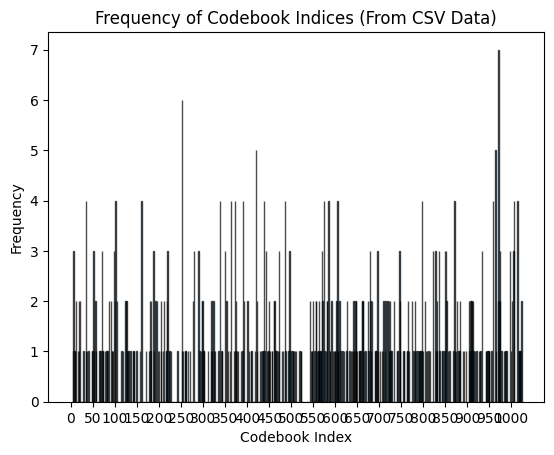

In [9]:
import csv

# 读取CSV文件并加载到字典中
index_count_from_csv = {}

with open('exp/1209_lowdim_CBDIM16/index_frequencies_0.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # 跳过表头
    for row in reader:
        index = int(row[0])
        frequency = int(row[1])
        index_count_from_csv[index] = frequency

print("Data loaded from CSV:", index_count_from_csv)
import matplotlib.pyplot as plt

# 提取所有索引的出现次数
frequencies_from_csv = list(index_count_from_csv.values())

# 绘制直方图
plt.bar(range(len(frequencies_from_csv)), frequencies_from_csv, edgecolor='black', alpha=0.7)
plt.title("Frequency of Codebook Indices (From CSV Data)")
plt.xlabel("Codebook Index")
plt.ylabel("Frequency")
plt.xticks(range(0, len(frequencies_from_csv), 50))  # 可调整间隔，防止标签过密
plt.show()
